# Data Preparation

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [6]:
# Where you want the dataset stored
data_dir = "./data"

# Simple transform (you can change later)
transform = transforms.Compose([
    transforms.ToTensor()
])

# This will:
# - CHECK if CIFAR-10 exists in data_dir
# - DOWNLOAD it if missing
train_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    transform=transform,
    download=True
)
print("CIFAR-10 ready!")
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

/home/wizard/deep_learning_ws/my_env/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


CIFAR-10 ready!
Train samples: 50000
Test samples: 10000


In [26]:
type(train_dataset)  # Should be torchvision.datasets.CIFAR100


torchvision.datasets.cifar.CIFAR10

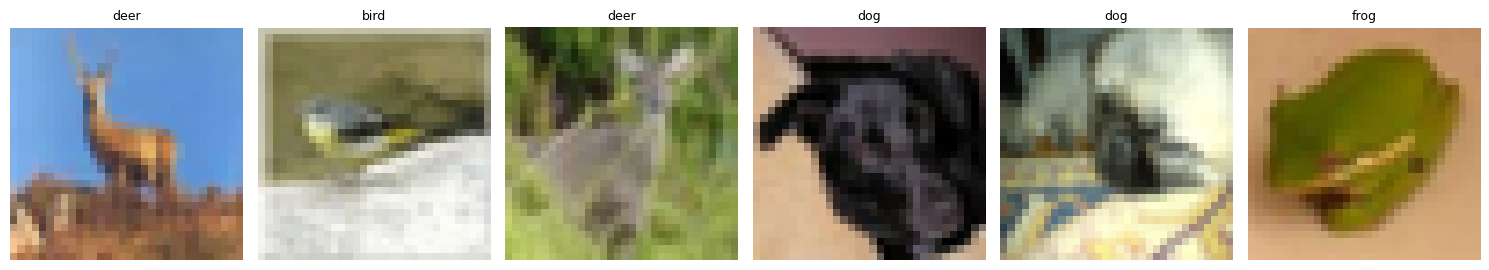

In [7]:


import random
import matplotlib.pyplot as plt

num_samples = 6
indices = random.sample(range(len(train_dataset)), num_samples)

plt.figure(figsize=(15, 3))

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(train_dataset.classes[label], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [28]:
type(image)  # Should be torch.Tensor
print(image.shape)  # Should be torch.Size([3, 32, 32])

torch.Size([3, 32, 32])


# Baseline Training

In [8]:
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
print("DataLoaders ready!")

DataLoaders ready!


In [9]:
model = models.resnet18(pretrained=False)


# Modify first layer for CIFAR
model.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=1, bias=False
)
model.maxpool = nn.Identity()

# Modify classifier
model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)


/home/wizard/deep_learning_ws/my_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wizard/deep_learning_ws/my_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [31]:
print(model.fc.in_features)

512


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [33]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    return running_loss / len(loader), acc


In [34]:
def evaluate(model, loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    return loss / len(loader), acc


In [35]:
num_epochs = 50

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


In [36]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    test_loss, test_acc = evaluate(
        model, test_loader, criterion
    )

    # Store values
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.2f}%")


Epoch [1/50]
  Train Loss: 1.2169, Train Acc: 55.65%
  Test  Loss: 1.0391, Test  Acc: 64.93%
Epoch [2/50]
  Train Loss: 0.7209, Train Acc: 74.47%
  Test  Loss: 0.6962, Test  Acc: 76.02%
Epoch [3/50]
  Train Loss: 0.5285, Train Acc: 81.60%
  Test  Loss: 0.6142, Test  Acc: 79.24%
Epoch [4/50]
  Train Loss: 0.4029, Train Acc: 85.86%
  Test  Loss: 0.6113, Test  Acc: 79.55%
Epoch [5/50]
  Train Loss: 0.2991, Train Acc: 89.44%
  Test  Loss: 0.5198, Test  Acc: 82.88%
Epoch [6/50]
  Train Loss: 0.2082, Train Acc: 92.73%
  Test  Loss: 0.7904, Test  Acc: 76.49%
Epoch [7/50]
  Train Loss: 0.1492, Train Acc: 94.75%
  Test  Loss: 0.6508, Test  Acc: 82.28%
Epoch [8/50]
  Train Loss: 0.1048, Train Acc: 96.38%
  Test  Loss: 0.7651, Test  Acc: 80.04%
Epoch [9/50]
  Train Loss: 0.0868, Train Acc: 96.90%
  Test  Loss: 0.7265, Test  Acc: 82.22%
Epoch [10/50]
  Train Loss: 0.0686, Train Acc: 97.56%
  Test  Loss: 0.7122, Test  Acc: 83.05%
Epoch [11/50]
  Train Loss: 0.0602, Train Acc: 97.87%
  Test  Loss: 0

# Baseline Evaluation

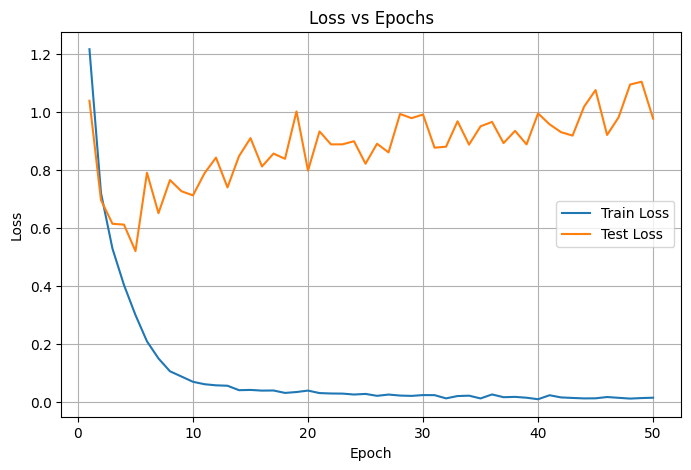

In [37]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


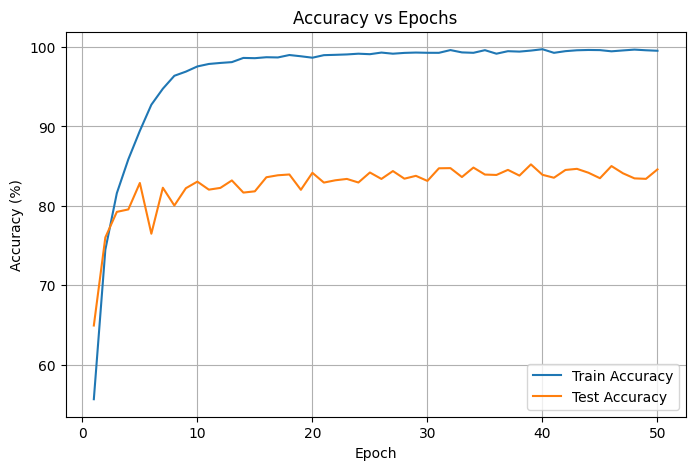

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import torch
import os

save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "resnet18_cifar10.pth")

In [ ]:
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

In [12]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [41]:
type(model)

torchvision.models.resnet.ResNet

In [42]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [13]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [14]:
import torch
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert lists → numpy arrays
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")


Accuracy  : 0.8459
Precision : 0.8476
Recall    : 0.8459
F1-score  : 0.8447


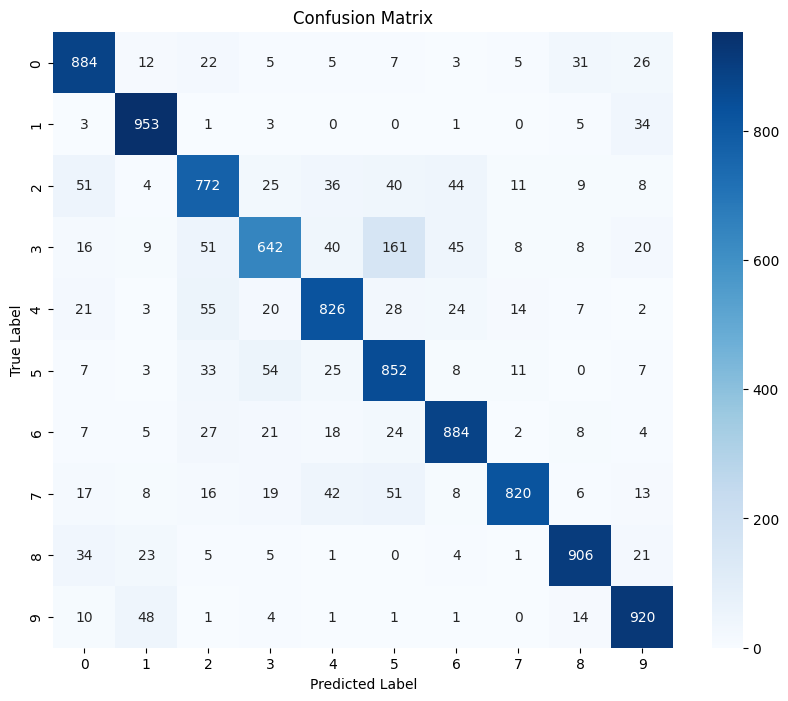

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Failure cases

# Modified-model training

# Modified-model Evaluation

# Performance Comparison